## Observer Design

Let consider the DC motor model

In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

J = 0.01;
b = 0.1;
K = 0.01;
R = 1;
l = 0.5;

A = np.array([[-b/J, K/J],[-K/l, -R/l]])
B = np.array([[0],[1/l]])
C = np.array([[1, 0]])

A = np.matrix(A)
B = np.matrix(B)
C = np.matrix(C)

n=A.shape[0]

If you want to know about the physical meaning of the parameters, please see the website
"https://ctms.engin.umich.edu/CTMS/index.php?example=MotorSpeed&section=SystemModeling"

Based on the above DC motor model, one can design a Luenburger observer as follows:
\begin{align}
&\dot{\hat{x}}(t)= A\hat{x}(t) +Bu(t) + L (y(t)-\hat{y}(t)),\tag{1},
\end{align}
where $y=Cx(t), \hat{y}=C\hat{x}(t)$, and $L$ denotes the Luenberger observer gain.

The error system between a plant (the DC motor) and the oberver (1) is represented as 
\begin{align}
\dot{e}(t) = (A-LC)e(t),
\end{align}
where $e(t)=x(t)-\hat{x}(t)$.

Now, we will focus on designing the $L$ gain. The LMI condition for designing the $L$ can be considered as the following code.

In [ ]:
Lbar = cp.Variable((n,B.shape[1]))
P = cp.Variable((n,n), PSD=True)
I = np.identity(n)

objective = cp.Minimize(0)
prob = cp.Problem(objective, [A.T*P.T-C.T*Lbar.T+P*A-Lbar*C + 0.001*I <= 0, P - 0.11*I >> 0])
prob.solve()

0.0

Let check the stability of the error system and obtain the $L$ gain.

In [ ]:
Pop = P.value
Lop = Lbar.value

Pinv = np.linalg.inv(Pop)
L = np.matmul(Pinv,Lop)

[sys_stab,sys_vec] = np.linalg.eig(A-L@C)
print(L)
print(sys_stab)

[[-10.0132056 ]
 [  1.04422336]]
[-0.9933972+0.2257746j -0.9933972-0.2257746j]


### Simulation

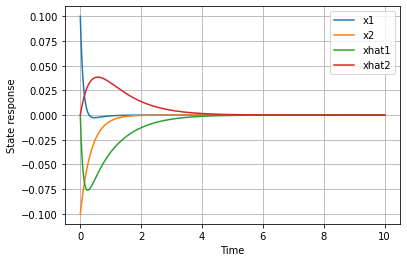

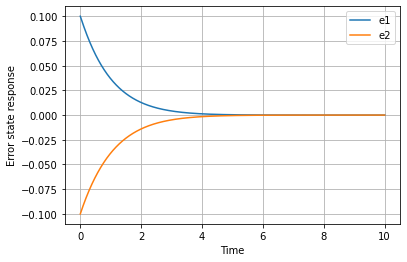

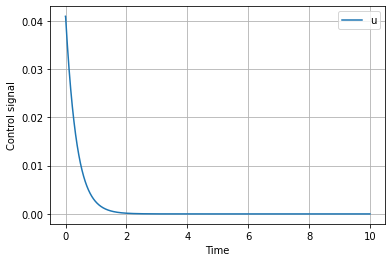

In [31]:
def plant(x,u):    
    J = 0.01;
    b = 0.1;
    K = 0.01;
    R = 1;
    l = 0.5;
    dx[0] = -(b/J)*x[0] + (K/J)*x[1] 
    dx[1] = -(K/l)*x[0] - (R/l)*x[1] + (1/l)*u
    return dx

def observer(x,xhat,u):    
    J = 0.01;
    b = 0.1;
    K = 0.01;
    R = 1;
    l = 0.5;
    dxhat[0] = -(b/J)*xhat[0] + (K/J)*xhat[1] - 10.0132056*(x[0]-xhat[0])
    dxhat[1] = -(K/l)*xhat[0] - (R/l)*xhat[1] + (1/l)*u + 1.04422336*(x[0]-xhat[0])
    return dxhat

def plant_rk(x,u,T):
    k1=plant(x,u)*T
    k2=plant(x+k1*0.5,u)*T
    k3=plant(x+k2*0.5,u)*T
    k4=plant(x+k3,u)*T
    dx = x + ((k1+k4)/6+(k2+k3)/3)
    return dx

def observer_rk(x,xhat,u,T):
    k1=observer(x,xhat,u)*T
    k2=observer(x,xhat+k1*0.5,u)*T
    k3=observer(x,xhat+k2*0.5,u)*T
    k4=observer(x,xhat+k3,u)*T
    dxhat = xhat + ((k1+k4)/6+(k2+k3)/3)
    return dxhat

x0 = np.array([[0.1],[-0.1]])
dx = np.zeros([2,1])
dxhat = np.zeros([2,1])
temp_p = np.zeros([2,1])
temp_ob = np.zeros([2,1])
T=0.001
tf=10
sam=int(tf/T)
tspan = np.linspace(0,tf, sam+1)

xs=len(tspan)
x=np.zeros([n,xs])
xhat=np.zeros([n,xs])
u_sig=np.zeros([B.shape[1],xs])
x[0,0]=x0[0]
x[1,0]=x0[1]

xhat[0,0]=0
xhat[1,0]=0

# K is obtained by using linear–quadratic regulator 
K = np.array([-0.0071, -0.4167])
K = np.matrix(K)
u_sig[:,0] = np.matmul(K,x[:,0])

for i in range(0,xs-1):
    u = np.matmul(K,x[:,i])

    temp_p[0] = x[0,i]
    temp_p[1] = x[1,i]
    
    temp_ob[0] = xhat[0,i]
    temp_ob[1] = xhat[1,i]
    
    plant_next = plant_rk(temp_p,u,T)
    ob_next = observer_rk(temp_p,temp_ob,u,T)
    
    x[0,i+1] = plant_next[0]
    x[1,i+1] = plant_next[1]

    xhat[0,i+1] = ob_next[0]
    xhat[1,i+1] = ob_next[1]

    u_sig[:,i+1] = u

plt.figure()
plt.plot(tspan, x[0,:], label = "x1")
plt.plot(tspan, x[1,:], label = "x2")
plt.plot(tspan, xhat[0,:], label = "xhat1")
plt.plot(tspan, xhat[1,:], label = "xhat2")
plt.grid()
plt.xlabel("Time")
plt.ylabel("State response")
plt.legend()
plt.show()

plt.figure()
plt.plot(tspan, x[0,:] - xhat[0,:], label = "e1")
plt.plot(tspan, x[1,:] - xhat[1,:], label = "e2")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Error state response")
plt.legend()
plt.show()


plt.figure()
plt.plot(tspan, u_sig[0,:], label = "u")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Control signal")
plt.legend()
plt.show()